[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aamodini/ghc-level-up-lab/blob/main/ghc_workshop.ipynb)

In [ ]:
# run this cell first to initialize the libraries required for this lab

! pip install seaborn==0.11.2
! pip install matplotlib==3.1.3
! pip install researchpy==0.3.2
! pip install xgboost==1.6.1
! pip install scipy==1.8.1
! pip install shap==0.41.0

# Tools for Understanding Ethical Concerns in Data and Modeling
## A Grace Hopper Level-Up Lab
**Authors: Alexandra Czachor, Emily White, Aamodini Gupta and Marlee Nichols**

In [2]:
# Data wrangling
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical analysis
import scipy.stats as stats
import researchpy as rp

# Machine Learning Classifier
from xgboost import XGBClassifier

# Data Partitioning
from sklearn.model_selection import train_test_split

# Classifier Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Machine Learning Explainer
import shap

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Problem Statment
#### Goal
- Uncover the potential biases in this dataset
    - Understanding proxy variables
- Build machine learning models to predict if an applicant is 'good' or 'bad' client
    - Understand the major drivers for the decisions made

**Kaggle Data Link (Reference)**: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

### Data Dictionary

## Bias is Everywhere: Data

### Enough data is needed to get a credible read on the signals used to make the predictions
When looking at the dataset, consider the follwoing questions:
- How much data do you have? is it enough?
- How was the data collected? 

In [3]:
# load raw datasets -- for comparison/demonstration
app_df = pd.read_csv('https://raw.githubusercontent.com/aamodini/ghc-level-up-lab/main/cc_raw_data/application_record.csv') # applicant level
app_df.set_index('ID', inplace=True) # set IDs as index 
credit_df = pd.read_csv('https://raw.githubusercontent.com/aamodini/ghc-level-up-lab/main/cc_raw_data/credit_record.csv') # applicant's past history -- month level 

# load cleaned dataset
cc_risk_df = pd.read_csv("https://raw.githubusercontent.com/aamodini/ghc-level-up-lab/main/cc_clean_data_20220913.csv") # format AMT_INCOME_TOTAL as int so its discrete 
cc_risk_df.set_index('ID', inplace=True) # set IDs as index 

In [4]:
print(f'Shape of raw dataset: {app_df.shape}')
print(f'Shape of cleaned dataset: {cc_risk_df.shape}')

Shape of raw dataset: (438557, 17)
Shape of cleaned dataset: (36457, 17)


#### Target Imbalance
- Target imbalance is common within classification type problems
- It happens when the proportion of one class is a lot smaller than the proportion of the other
- Look at the counts of the target to understand the level of imbalance with your dataset
- The severity of the class imbalance can help inform what steps you need to take to address it such as which algorithms to consider, how you partition your data, and more

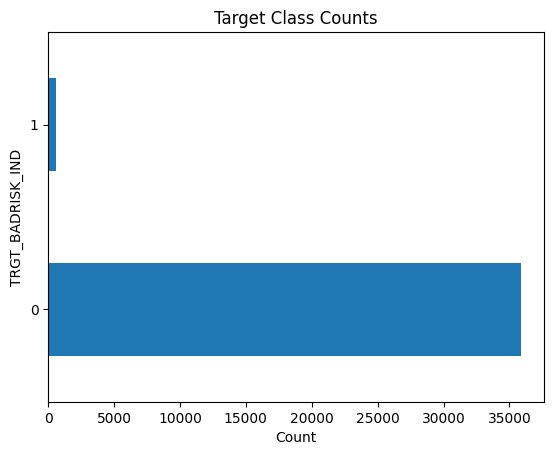

In [49]:
cc_risk_df['TRGT_BADRISK_IND'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('TRGT_BADRISK_IND')
plt.title('Target Class Counts')
plt.show()

### Data manipulation can reduce important information

- The distribution of Income is skewed to the right (refer to historgram below)
- There are a lot of outliers (refer to box plot below)
- Therefore, **median** is a better choice than mean to understand the data distributions 

Choice of **Median**:
- Median is a more robust metric than mean. A robust metric is one that is less affected by outliers, making median a better choice than mean
- Using mean may give an incomplete picture of the data distribution

In [6]:
# show dataset
cc_risk_df.groupby('CODE_OCCUPATION_TYPE').agg(
       min_income=pd.NamedAgg(column='AMT_INCOME_TOTAL', aggfunc=min),
       max_income=pd.NamedAgg(column='AMT_INCOME_TOTAL', aggfunc=max),
       average_income=pd.NamedAgg(column='AMT_INCOME_TOTAL', aggfunc=np.mean),
   ) 

,min_income,max_income,average_income
CODE_OCCUPATION_TYPE,,,
Accountants,45000.0,661500.0,202463.865834
Cleaning staff,31500.0,450000.0,149141.107078
Cooking staff,40500.0,495000.0,146517.251908
Core staff,36000.0,990000.0,190172.786967
Drivers,58500.0,900000.0,209797.240412
HR staff,112500.0,675000.0,193764.705882
High skill tech staff,54000.0,900000.0,196053.579176
IT staff,103500.0,540000.0,199860.000000
Laborers,36000.0,900000.0,179794.282402


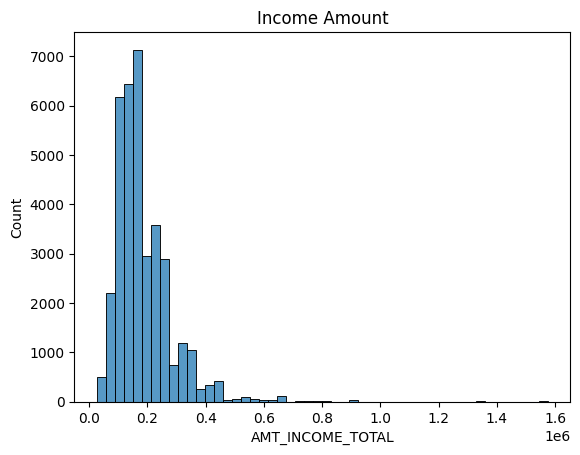

In [7]:
# show the distribution of Income Amount
sns.histplot(data=cc_risk_df, x='AMT_INCOME_TOTAL', bins=50)
plt.title('Income Amount')
plt.show()

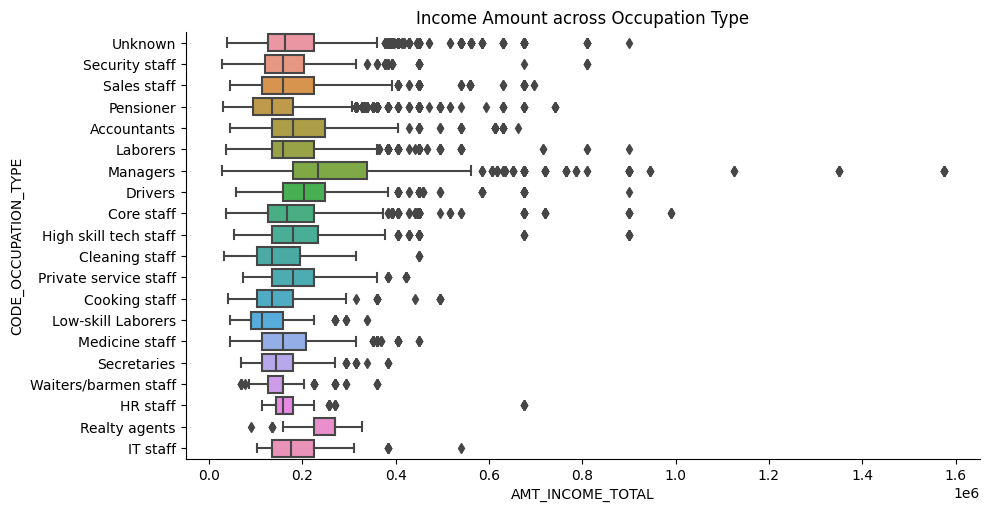

In [8]:
# Boxplots of AMT_INCOME_TOTAL by CODE_OCCUPATION_TYPE
# This gives us a visual of the income outliers across for each group
sns.catplot(
    data=cc_risk_df, 
    y='CODE_OCCUPATION_TYPE', 
    x='AMT_INCOME_TOTAL', 
    kind='box', 
    height=5, 
    aspect=2,
    orient = 'h')
plt.title('Income Amount across Occupation Type')
plt.show()

### Investigate missing values
- It is important to understand the missing values in the dataset
Reasons for missingness:
- Missing values can be randomly missing (due to errors in data collection) 
    - Dropping the missing values in this case 
    - Impute the missing values
- Missing values can have meaning
    - Dropping the missing values in this case may result in loss of important information
    - Impute the missing values as another category 

In [9]:
app_df.isna().sum() # sum of missing rows in each column (raw data)

CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [10]:
app_df[['OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'DAYS_EMPLOYED']][app_df['OCCUPATION_TYPE'].isna()]

,OCCUPATION_TYPE,NAME_INCOME_TYPE,DAYS_EMPLOYED
ID,,,
5008804,NaN,Working,-4542
5008805,NaN,Working,-4542
5008812,NaN,Pensioner,365243
5008813,NaN,Pensioner,365243
5008814,NaN,Pensioner,365243
...,...,...,...
6840098,NaN,Pensioner,365243
6840100,NaN,Pensioner,365243
6840102,NaN,Pensioner,365243


In [11]:
(cc_risk_df['CODE_OCCUPATION_TYPE'].value_counts(normalize=True)*100).round(2)

Laborers                 17.04
Pensioner                16.83
Unknown                  14.23
Core staff                9.85
Sales staff               9.56
Managers                  8.26
Drivers                   5.86
High skill tech staff     3.79
Accountants               3.40
Medicine staff            3.31
Cooking staff             1.80
Security staff            1.62
Cleaning staff            1.51
Private service staff     0.94
Low-skill Laborers        0.48
Waiters/barmen staff      0.48
Secretaries               0.41
HR staff                  0.23
Realty agents             0.22
IT staff                  0.16
Name: CODE_OCCUPATION_TYPE, dtype: float64

In [12]:
cc_risk_df.isna().sum()

CNT_CHILDREN            0
AMT_INCOME_TOTAL        0
NAME_INCOME_TYPE        0
NAME_EDUCATION_TYPE     0
NAME_FAMILY_STATUS      0
NAME_HOUSING_TYPE       0
DAYS_BIRTH              0
FLAG_WORK_PHONE         0
FLAG_PHONE              0
FLAG_EMAIL              0
CNT_FAM_MEMBERS         0
TRGT_BADRISK_IND        0
CODE_OCCUPATION_TYPE    0
CNT_DAYS_EMPLOYED       0
FLAG_OWN_REALTY_OHE     0
FLAG_OWN_CAR_OHE        0
CODE_GENDER_F           0
dtype: int64

### Decide if the data should be representative of the population, what will be seen in production, or sampled in a specific way
#### Population Parameters

In [13]:
# overall numerical summary stats
# the 50% is the median value 
cc_risk_df.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,TRGT_BADRISK_IND,CNT_DAYS_EMPLOYED,FLAG_OWN_REALTY_OHE,FLAG_OWN_CAR_OHE,CODE_GENDER_F
count,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,0.430315,1.866857e+05,15975.173382,0.225526,0.294813,0.089722,2.198453,0.016897,2200.317168,0.672189,0.379708,0.670105
std,0.742367,1.017892e+05,4200.549944,0.417934,0.455965,0.285787,0.911686,0.128886,2366.796762,0.469422,0.485321,0.470181
min,0.000000,2.700000e+04,7489.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.215000e+05,12462.000000,0.000000,0.000000,0.000000,2.000000,0.000000,408.000000,0.000000,0.000000,0.000000
50%,0.000000,1.575000e+05,15563.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1552.000000,1.000000,0.000000,1.000000
75%,1.000000,2.250000e+05,19438.000000,0.000000,1.000000,0.000000,3.000000,0.000000,3153.000000,1.000000,1.000000,1.000000
max,19.000000,1.575000e+06,25152.000000,1.000000,1.000000,1.000000,20.000000,1.000000,15713.000000,1.000000,1.000000,1.000000


**Numerical Data Takeaways:**
- There are more F than M in the dataset (67% of the population is F)
    * Assume this dataset is representative of the population we will get at the time of production
    * `CODE_GENDER_F` is a protected class so make sure this variable is not a part of the model
- The min and max birthdays make sense (18-69 years of age)
- We've already established that the target is highly imbalanced. This is again reflective in this descriptive table with a `mean = 0.016897`
- The rest of the numeric variables have sensible/reasonable values as well.

**Note**    
- Depending upon the needs of the team, identify what is right FOR YOUR PROJECT:
    * Training on the population of the general demographics
    * OR Training on the population of the target demographics

In [14]:
cc_risk_df.describe(include='object')

,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,CODE_OCCUPATION_TYPE
count,36457,36457,36457,36457,36457
unique,5,5,5,6,20
top,Working,Secondary / secondary special,Married,House / apartment,Laborers
freq,18819,24777,25048,32548,6211


**Categorial Data Takeaways:**
- 20 different Occupation Types
- 89.2% of the data has the House/apartment housing type
- 68.7% of the applicants are married 
- 68% are educated up till the secondary school level

## Bias is Everywhere: Model

### Identify features that are proxy variables to the protected class variable before modeling

**Proxy Variable**:

- A proxy to a variable is typically characterised by a high, statistically significant correlation between the two variables.
- If a proxy variable is kept as a part of the final model, the proxy will act like the protected class variable and it would be like you never dropped that protected class variable. 
    * The bias you hoped to remove from your model will still remain, even if you've taken out the protected class variable. 

**Goal:** Identify any *significant* correlations between the protected class and the rest of the variables in the dataset.
- In this example we’re going to use the 3 variables in our dataset that relate to employment, specifically focusing on the relationship between `AMT_INCOME_TOTAL` and `CODE_GENDER_F`

**Identifying Proxy Variables or Variables of Interest**
- Protected Class Variable: `CODE_GENDER_F`
    * Drop variable from modeling
- Correlation Analysis:
    * Correlations can get tricky here because relationships between variables are not always linear
        - More familiar: Pearson correlation 
        - Measures the strength of the linear relationship between two variables
    * Use the `chi-square` significance test to to identify the correlated variables
        - The test in this example, is used to determine if there is a correlation between two discrete/categorical variables.
        - A significant correlation between protected class and another variable in our dataset tells us that at a selected `alpha` level, there is a correlation and that correlation is NOT due to random chance. There is an underlying effect that is causing the correlation to show up.
        - This test does not show the strength of the correlation
    * Use the variables that show a non zero correlation and DOCUMENT it
        - Keep an eye on these variables during model evaluation
        - See how important the particular feature is for the model to make decisions
            * sneak: feature importance and SHAP

In [15]:
cc_risk_df[['CODE_GENDER_F', 'AMT_INCOME_TOTAL', 'CNT_DAYS_EMPLOYED']].groupby('CODE_GENDER_F').median()

,AMT_INCOME_TOTAL,CNT_DAYS_EMPLOYED
CODE_GENDER_F,,
0,202500.0,1595.0
1,157500.0,1526.0


**Takeaways**

- Median `AMT_INCOME_TOTAL`, F < M
- Median `CNT_DAYS_EMPLOYED`, F < M

Based on the interesting variables around employment itself, it might be a good idea to take a look at income and days employed by `CODE_OCCUPATION_TYPE`

#### Income by Gender and Occupation Type

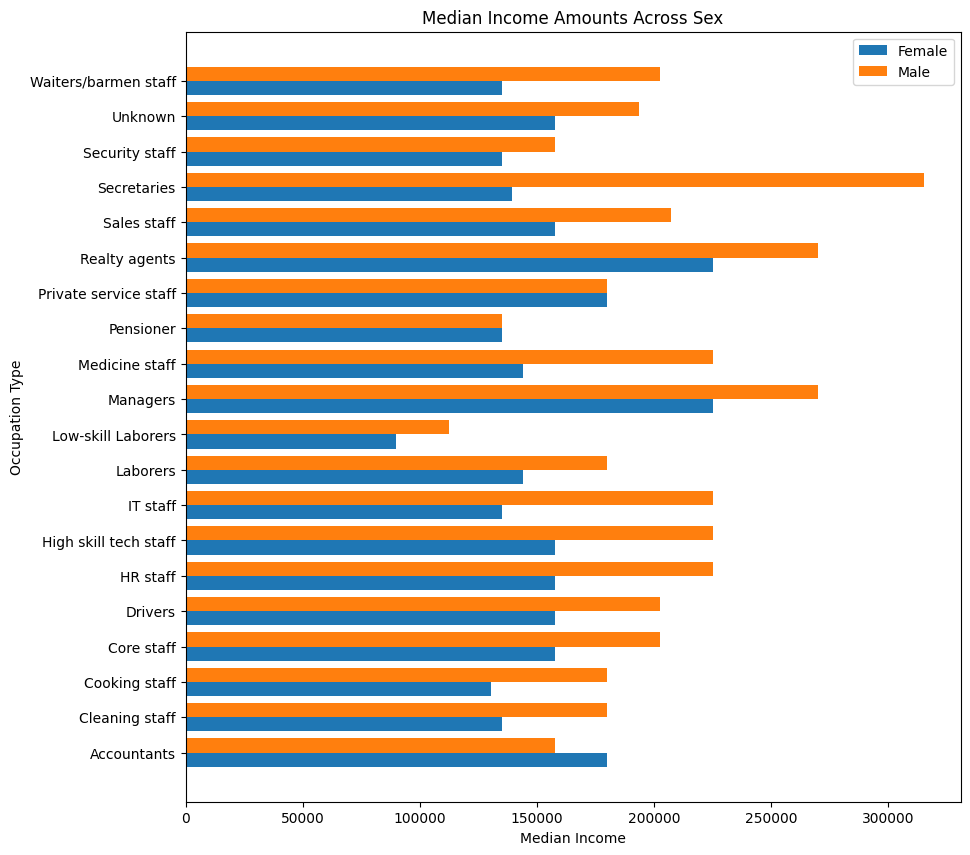

In [16]:
# create dataset for median
df_M_med = cc_risk_df[cc_risk_df['CODE_GENDER_F']==0].groupby('CODE_OCCUPATION_TYPE').median().reset_index()
df_F_med = cc_risk_df[cc_risk_df['CODE_GENDER_F']==1].groupby('CODE_OCCUPATION_TYPE').median().reset_index()

# create dataset for mean
df_M_mean = cc_risk_df[cc_risk_df['CODE_GENDER_F']==0].groupby('CODE_OCCUPATION_TYPE').mean().reset_index()
df_F_mean = cc_risk_df[cc_risk_df['CODE_GENDER_F']==1].groupby('CODE_OCCUPATION_TYPE').mean().reset_index()

# subset 
df_comp_income_med = df_F_med.loc[:,('CODE_OCCUPATION_TYPE', 'AMT_INCOME_TOTAL')]
df_comp_income_med.set_index('CODE_OCCUPATION_TYPE', inplace=True)
df_comp_income_med.rename({'AMT_INCOME_TOTAL': 'AMT_INCOME_MED_F'}, axis=1, inplace=True)

df_comp_income_med['AMT_INCOME_MED_M'] = cc_risk_df[cc_risk_df['CODE_GENDER_F']==0].groupby('CODE_OCCUPATION_TYPE').median()['AMT_INCOME_TOTAL']
df_comp_income_med['INCOME_F_GE_M'] = np.select([df_comp_income_med['AMT_INCOME_MED_M'] <= df_comp_income_med['AMT_INCOME_MED_F']],[1],default=0)
df_comp_income_med['INCOME_F_MINUS_M'] = df_comp_income_med['AMT_INCOME_MED_F'] - df_comp_income_med['AMT_INCOME_MED_M']

# plot
fig, ax = plt.subplots(figsize=(10, 10))

occ_type = df_comp_income_med.index.tolist()
y_axis = np.arange(len(occ_type))

plt.barh(y_axis - 0.2, df_comp_income_med['AMT_INCOME_MED_F'], 0.4, label = 'Female')
plt.barh(y_axis + 0.2, df_comp_income_med['AMT_INCOME_MED_M'], 0.4, label = 'Male')

plt.yticks(y_axis, occ_type)
plt.ylabel("Occupation Type")
plt.xlabel("Median Income")
plt.title("Median Income Amounts Across Sex")
plt.legend()
plt.show()

**Takeaways**
- **Observations**: 
    1. It is immediately obvious that in a majority of the occupations, men earn higher incomes that women do. `Accountants` is the only occupation type in which women earn a higher median wage than men. 
        - There are only 2 other occupation types in which the median for women and men are the same. Otherwise, men make higher wages than women do in 17/20 occupation categories.
    2. The difference in wages is considerable (all median wages have a difference of at least 22,500). 
- **Consequence**: 
    * The difference in income between men and women that we saw earlier in our descpriptive analysis cannot be attributed to occupation type, because it looks like in each of the categories men have consistently higher wages than women. 
- **Possible alternative explanation**: 
    * Maybe men tend to stay longer at their jobs overall, which attribute to higher wages?

#### Days Employed by Gender and Occupation Type

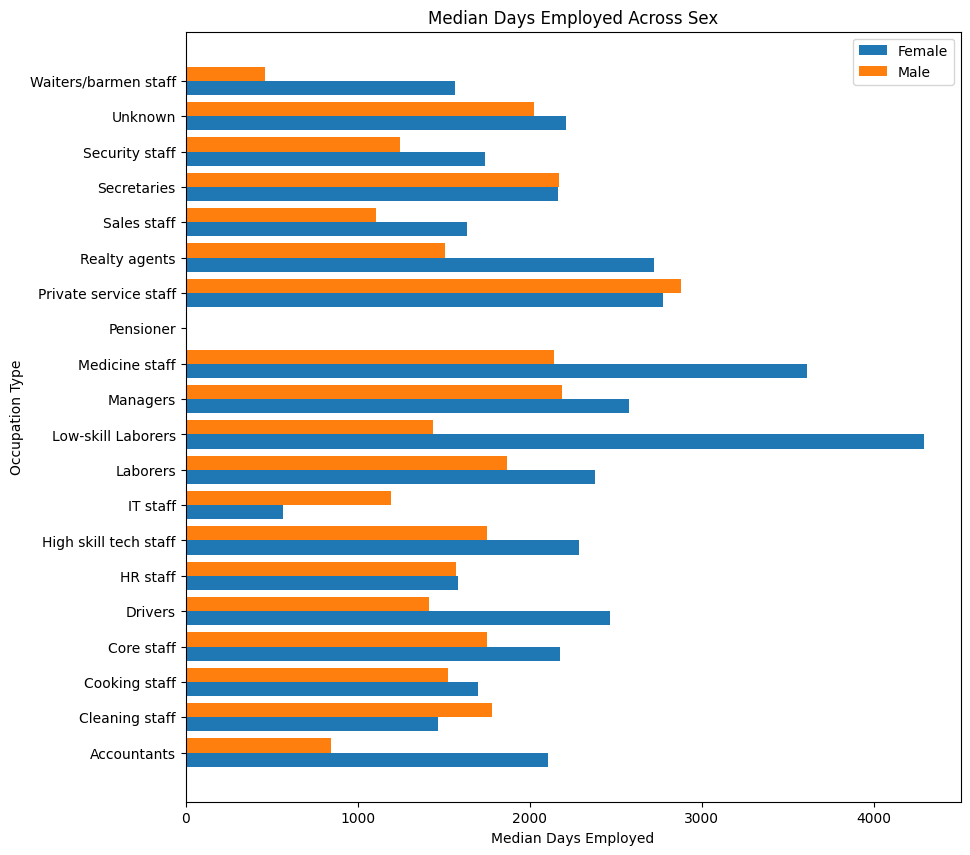

In [17]:
# subset
df_comp_emp_med = df_F_med.loc[:,('CODE_OCCUPATION_TYPE', 'CNT_DAYS_EMPLOYED')]
df_comp_emp_med.set_index('CODE_OCCUPATION_TYPE', inplace=True)
df_comp_emp_med.rename({'CNT_DAYS_EMPLOYED': 'DAYS_EMPLOYED_MED_F'}, axis=1, inplace=True)

df_comp_emp_med['DAYS_EMPLOYED_MED_M'] = cc_risk_df[cc_risk_df['CODE_GENDER_F']==0].groupby('CODE_OCCUPATION_TYPE').median()['CNT_DAYS_EMPLOYED']
df_comp_emp_med['INCOME_F_GE_M'] = np.select([df_comp_emp_med['DAYS_EMPLOYED_MED_M'] <= df_comp_emp_med['DAYS_EMPLOYED_MED_F']],[1],default=0)
df_comp_emp_med['INCOME_F_MINUS_M'] = df_comp_emp_med['DAYS_EMPLOYED_MED_F'] - df_comp_emp_med['DAYS_EMPLOYED_MED_M']

# plot
fig, ax = plt.subplots(figsize=(10, 10))

occ_type = df_comp_emp_med.index.tolist()
y_axis = np.arange(len(occ_type))

plt.barh(y_axis - 0.2, df_comp_emp_med['DAYS_EMPLOYED_MED_F'], 0.4, label = 'Female')
plt.barh(y_axis + 0.2, df_comp_emp_med['DAYS_EMPLOYED_MED_M'], 0.4, label = 'Male')

plt.yticks(y_axis, occ_type)
plt.ylabel("Occupation Type")
plt.xlabel("Median Days Employed")
plt.title("Median Days Employed Across Sex")
plt.legend()
plt.show()

**Takeaways**

- **Observations**:
    1. Here again the results are obvious. Women overall have a higher median days employed in most of these categories. Which means that women overall are spending more time at their jobs.
    2. The `IT Staff` occupation type is the only one in which men have worked longer than women by more than 365 days 
        * Occupation Types `Cleaning staff`, `Private service staff` and `Secretaries` are the only other occupation types in which men have worked longer than women. But in these categories, the difference of length of employment is under 365 days.
- **Consequences**:
    * The difference in days employed between men and women cannot be attributed to occupation type, because it looks like in each of the categories women have consistently worked longer than men.

**What's next?**

By this, we now know that there is SOME relationship between gender and income. But is this relationship statistically significant?

#### Significance Testing - Chi Square

- The null hypothesis (`H0`) of the chi square states that the two groups have no relationship and are independent
- We need compelling evidence (set `alpha = 0.05`) to say that there is a significant correlation between the two variables
    * If the test fails to reject the null hypothesis, it implies that there is a non zero correlation between the two variables. 
    

*Assumptions*
- Consider `AMT_INCOME_TOTAL` as a discrete variable. 

In [18]:
chi2_df = pd.crosstab(cc_risk_df['CODE_GENDER_F'], cc_risk_df['AMT_INCOME_TOTAL'], margins=False) # setup data for chi-2
stat, p, dof, expected = stats.chi2_contingency(chi2_df) # generate chi2 stats, p-values and other test metrics

# interpret p-value
alpha = 0.05
if p <= alpha:
	print('Reject H0: There is a statistically significant correlation between the two features.')
else:
	print('Fail to Reject H0: There is no statistically significant correlation between the two features. The features are independent.')

print(f'Significance Level Alpha: {alpha}')
print(f'p-Value: {p}')


Reject H0: There is a statistically significant correlation between the two features.
Significance Level Alpha: 0.05
p-Value: 0.0


**Takeaways**

- The chi-squared test shows that gender and income are correlated. 
- We do not know the strength of this correlation. 
    * DOCUMENT this
    * Keep an eye on these variables during model evaluation

#### Identifying the Predictive Model

**Prepare Data for Modeling: One Hot Encoding**

In [19]:
# identify variables to one hot encode
ohe_vars = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'CODE_OCCUPATION_TYPE']

# generate dummy df 
dummy_df = pd.DataFrame()
for i in ohe_vars:
    temp_df = pd.get_dummies(data=cc_risk_df[i]).add_prefix(f'{i}_') # generate descriptive variable names
    dummy_df = pd.concat([dummy_df, temp_df], axis=1) # add columns to the ohe dataset

# create transformed dataset
df_trans = pd.concat([cc_risk_df[[i for i in cc_risk_df.columns.tolist() if i not in ohe_vars]], dummy_df], axis=1)
df_trans

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,TRGT_BADRISK_IND,CNT_DAYS_EMPLOYED,FLAG_OWN_REALTY_OHE,...,CODE_OCCUPATION_TYPE_Managers,CODE_OCCUPATION_TYPE_Medicine staff,CODE_OCCUPATION_TYPE_Pensioner,CODE_OCCUPATION_TYPE_Private service staff,CODE_OCCUPATION_TYPE_Realty agents,CODE_OCCUPATION_TYPE_Sales staff,CODE_OCCUPATION_TYPE_Secretaries,CODE_OCCUPATION_TYPE_Security staff,CODE_OCCUPATION_TYPE_Unknown,CODE_OCCUPATION_TYPE_Waiters/barmen staff
ID,,,,,,,,,,,,,,,,,,,,,
5008804,0,427500.0,12005,1,0,0,2,0,4542,1,...,0,0,0,0,0,0,0,0,1,0
5008805,0,427500.0,12005,1,0,0,2,0,4542,1,...,0,0,0,0,0,0,0,0,1,0
5008806,0,112500.0,21474,0,0,0,2,0,1134,1,...,0,0,0,0,0,0,0,1,0,0
5008808,0,270000.0,19110,0,1,1,1,0,3051,1,...,0,0,0,0,0,1,0,0,0,0
5008809,0,270000.0,19110,0,1,1,1,0,3051,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,1,157500.0,10808,0,0,0,3,0,1739,1,...,0,0,0,0,0,0,0,0,0,0
5150483,1,157500.0,10808,0,0,0,3,0,1739,1,...,0,0,0,0,0,0,0,0,0,0
5150484,1,157500.0,10808,0,0,0,3,0,1739,1,...,0,0,0,0,0,0,0,0,0,0


#### Data Splits 
- Dataset is small so split only into train and test
- You can split Train into Train and Validation and get the Train/Validation/Test set

### Stratify on the target to get an equal target rate in all the different data splits
- We already know that our target is imbalanced
- If data is split without stratification, it is possible to end up with a dataset without any 'bad risk' (which is the minority class)
- The model, during training, needs to have a full representative dataset so it can find patterns that are more generalized
    - This is a general best practice to get the best model results
    - The test data can be subsetting to reflect what is expected during production

**TRAIN/TEST SPLIT**

In [20]:
X = df_trans[[i for i in df_trans.columns.tolist() if i != 'TRGT_BADRISK_IND']] # remove the interest rate variable
y = df_trans['TRGT_BADRISK_IND']

# notice the stratification with y
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4738, stratify=y)

In [21]:
print(f'Percentage of minority in the full dataset: {round(100*y.value_counts()[1]/(y.value_counts()[0]+y.value_counts()[1]), 2)}%')
print(f'Percentage of minority in the train dataset: {round(100*y_train.value_counts()[1]/(y_train.value_counts()[0]+y_train.value_counts()[1]), 2)}%')
print(f'Percentage of minority in the test dataset: {round(100*y_test.value_counts()[1]/(y_test.value_counts()[0]+y_test.value_counts()[1]), 2)}%')

Percentage of minority in the full dataset: 1.69%
Percentage of minority in the train dataset: 1.69%
Percentage of minority in the test dataset: 1.69%


In [22]:
full_df = X['CODE_GENDER_F'].value_counts()
train_df = X_train_pre['CODE_GENDER_F'].value_counts()
test_df = X_test_pre['CODE_GENDER_F'].value_counts()

print(f'Percentage of females in the full dataset: {round(100*full_df[1]/(full_df[0]+full_df[1]), 2)}%')
print(f'Percentage of females in the train dataset: {round(100*train_df[1]/(train_df[0]+train_df[1]), 2)}%')
print(f'Percentage of females in the test dataset: {round(100*test_df[1]/(test_df[0]+test_df[1]), 2)}%')

Percentage of females in the full dataset: 67.01%
Percentage of females in the train dataset: 66.65%
Percentage of females in the test dataset: 68.46%


**MODEL CREATION**

*Assume that feature selection was done*

In [23]:
# results from feature selection

feat_selected = [
    'CNT_DAYS_EMPLOYED',
    'NAME_FAMILY_STATUS_Single / not married',
    'CODE_OCCUPATION_TYPE_Core staff',
    'AMT_INCOME_TOTAL',
    'NAME_FAMILY_STATUS_Married',
    'CODE_OCCUPATION_TYPE_Unknown',
    'FLAG_OWN_CAR_OHE',
    'NAME_INCOME_TYPE_Working',
    'DAYS_BIRTH',
    'NAME_HOUSING_TYPE_House / apartment',
    'NAME_INCOME_TYPE_Pensioner',
    'FLAG_PHONE',
    'CNT_FAM_MEMBERS',
    'FLAG_EMAIL',
    'NAME_EDUCATION_TYPE_Secondary / secondary special',
    'CODE_OCCUPATION_TYPE_Laborers',
    'NAME_EDUCATION_TYPE_Higher education',
    'FLAG_WORK_PHONE',
    'CNT_CHILDREN',
    'FLAG_OWN_REALTY_OHE',
    'NAME_INCOME_TYPE_Commercial associate'
 ]

**Class Weighted XGBoost**

- XGBoost has a range of hyperparameters that you can tune
- The hyperparameter `scale_pos_weight` offers a way to tune the training algorithm to pay more attention to misclassification of the minority class for datasets with a skewed class distribution.
- The XGBoost documentation suggests a fast way to estimate this value
    * This example uses the training data.
    * Total number of examples in the majority class divided by the total number of examples in the minority class.

In [24]:
X_train = X_train_pre[feat_selected]
X_test = X_test_pre[feat_selected]

In [25]:
xgb_model = XGBClassifier(
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1], 
    random_state=0)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [26]:
# get train predictions and probabilities
y_pred_train = xgb_model.predict(X_train)
y_pred_train_prob = xgb_model.predict_proba(X_train)

# get test predictions and probabilities
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)

### Identify important metrics on which to evaluate the model

#### Evaluating the model
- What metric should be used to evaluate the model?
- The wrong metric can show an artifically high performance!

**ACCURACY**
- Calculated by: (Number of Total Correct Predictions)/(Total Number of Obeservations)
- What would the accuracy be if the model predicted all 0s? 
    * The target rate is 1.69%
    * Accuracy would be 98.31% because it would only render an incorrect prediction 1.69% of the time (which is our target rate)
    * Not the best metric to use to measure the model's performance

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.99%


**CONFUSION MATRIX**
- Reading the 4 quadrants of the test confusion matrix:
    * True Negative: `6868` people were classified by the model as a `good risk`, when they were *actually* a `good risk`
    * False Positive: `301` people were classified by the model as a `bad risk`, when they were *actually* a `good risk` 
    * False Negative: `64` people were classified by the model as a `good risk`, when they were *actually* a `bad risk`
    * True Positive: `59` people were classified by the model as a `bad risk`, when they were *actually* a `bad risk`
- The train confusion matrix shows that there were no false negatives during training.
    * This tells us that the model may have overfit
    * Tip: XGBoost has a lot of parameters that can be tuned. There are specific parameters that can be tweaked to account for overfitting!

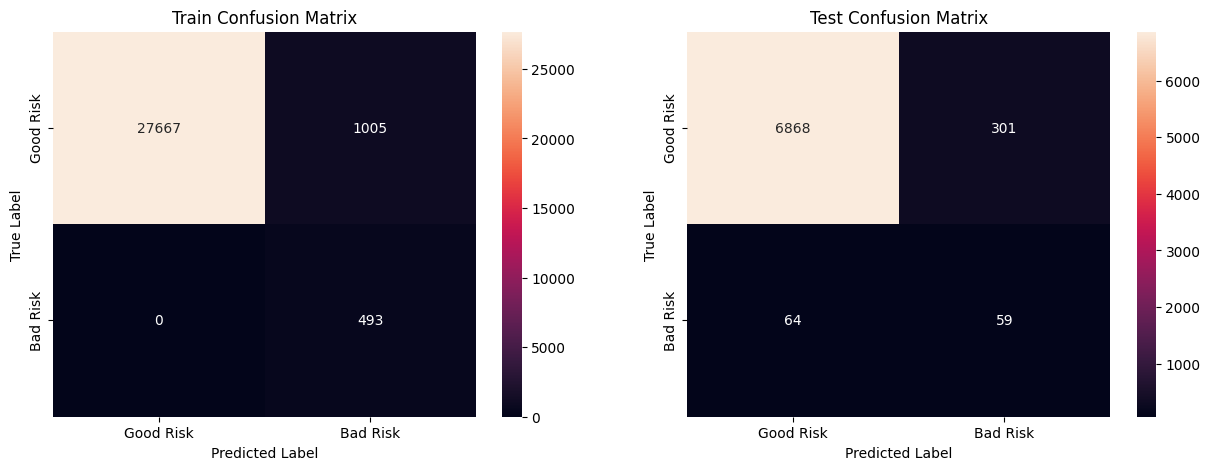

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))

# --------------------------------------------
# TN = True Negative  |  FP = False Positive |
# ------------------- + ----------------------
# FN = False Negative |  TP = True Positive  |
# --------------------------------------------

# train confusion matrix
plt.subplot(1, 2, 1)
conf_matrix_train = confusion_matrix(y_train, y_pred_train) # generate confusion matrix for train

sns.heatmap(conf_matrix_train, annot=True, fmt="d", xticklabels=['Good Risk', 'Bad Risk'], yticklabels=['Good Risk', 'Bad Risk'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')

# test confusion matrix
plt.subplot(1, 2, 2)
conf_matrix = confusion_matrix(y_test, y_pred) # generate confusion matrix for test

sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['Good Risk', 'Bad Risk'], yticklabels=['Good Risk', 'Bad Risk'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()


**Receiver Operating Characteristic/Area Under the Curve (ROC/AUC)**:

- It tells how much the model is capable of distinguishing between classes
    * It plots the probability that an actual negative will test negative (False Positive Rate) against probability that an actual positive will test positive (True Positive Rate)
- Higher the AUC, the better the model is at predicting a bad risk as a bad risk and good risk as a good risk

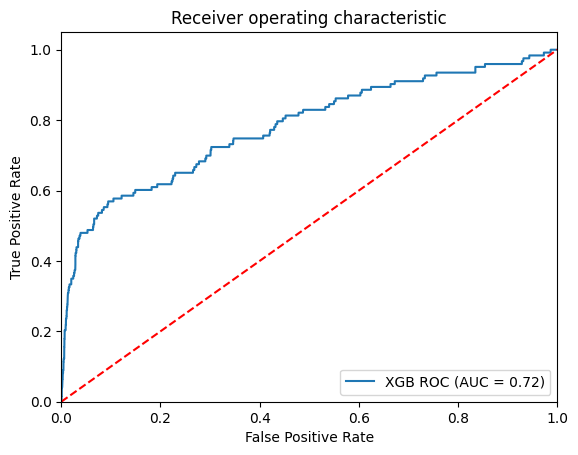

In [29]:
xgb_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])

plt.figure()
plt.plot(fpr, tpr, label='XGB ROC (AUC = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('TRGT_no_oversample_ROC')
plt.show()

### Understand which variables are driving model predictions

**FEATURE IMPORTANCE**

- Gain importance quantifies the relative contribution of the corresponding feature to the model
- How important is `AMT_INCOME_TOTAL` to the model?

In [30]:
# get importance
model_imp = xgb_model.get_booster().get_score(importance_type= 'gain')

# create df for that importance
gain_imp_df = pd.DataFrame()
gain_imp_df['Features'] = list(model_imp.keys())
gain_imp_df['Gain Importance'] = list(model_imp.values())

# get top 30 
gain_imp_sorted = gain_imp_df.sort_values(by='Gain Importance', ascending=False).iloc[0:30]


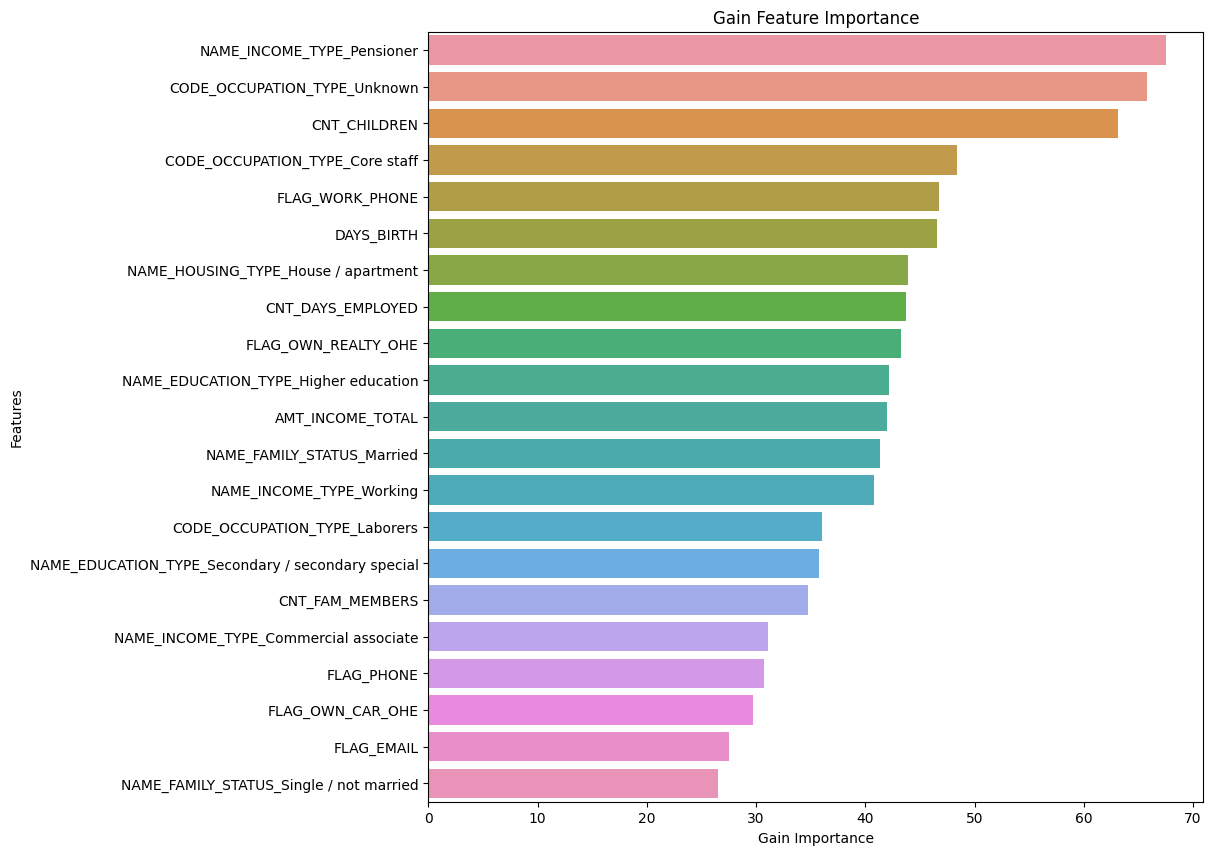

In [31]:
fig = plt.figure(figsize = (10, 10))
sns.barplot(x="Gain Importance", y="Features", data=gain_imp_sorted)
plt.title('Gain Feature Importance')
plt.show()

### Use SHAP to further understand feature importance

- SHAP (SHapley Additive exPlanations) is another model that aims to explain the predictions of machine learning models
- Model generates Shapley values, a concept that comes from game theory
    * It is a value that quantifies how much each feature contributed to an individual prediction made by the model
- Notice that `AMT_INCOME_TOTAL` is a part of the top 3 variables that contribute to the individual model decisions
    * Document the importance of this variable to the model
    * Consult with your team to make a decision if income should be included in the final model or not

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


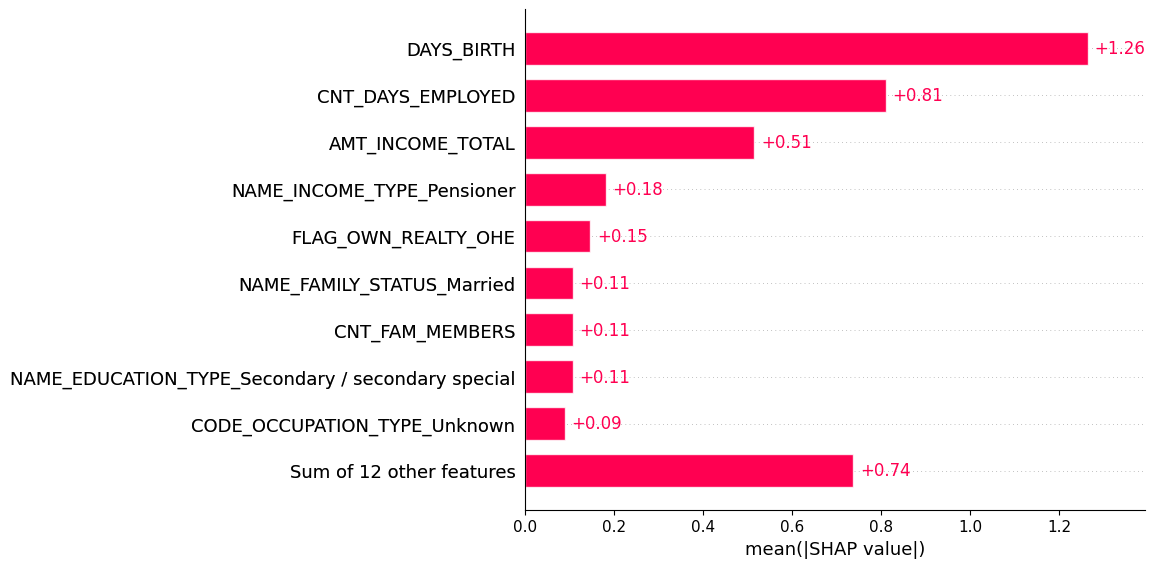

In [32]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train) 

# plot of mean absolute value for each feature column -- aggregates the individual shap values
shap.plots.bar(shap_values)

**Takeaways**
- We're looking at the aggregated Shapley values of the individual contributions
- `AMT_INCOME_TOTAL` shows up as the third highest in this which indicates to me that for individual predictions, the model on average leverages income to a high extent
- At this point, knowing how important Income turned out to be, I would advice to not include `AMT_INCOME_TOTAL` in the final model 

## Bias is Everywhere: Impact

Try to understand if the model decisions are "fair" across subsets of people

#### Model Predictions Across Population Subsets
- What are some subsets you want to evaluate your model on?
- Are model predictions favoring a certain population subset over others? 
- Which variables did the model favor for a given prediction
    - Here use SHAP to understand how a prediction is generated 


In [33]:
# generate evaluation dataset
df_eval = X_test_pre.loc[:, ('CODE_GENDER_F', 'AMT_INCOME_TOTAL')]
df_eval['TEST'] = y_test.tolist()
df_eval['PRED'] = y_pred.tolist()
df_eval['PRED_PROB_1'] = y_pred_prob[:,1].tolist()
df_eval['Misses'] = np.select([(df_eval['TEST'] != df_eval['PRED'])], [1], default=0)

# female
y_pred_prob_F = df_eval['PRED_PROB_1'][df_eval['CODE_GENDER_F'] == 1].tolist()
y_test_F = df_eval['TEST'][df_eval['CODE_GENDER_F'] == 1].tolist()

# male
y_pred_prob_M = df_eval['PRED_PROB_1'][df_eval['CODE_GENDER_F'] == 0].tolist()
y_test_M = df_eval['TEST'][df_eval['CODE_GENDER_F'] == 0].tolist()

**THRESHOLDING**

In [34]:
# --------------------------------------------
# TN = True Negative  |  FP = False Positive |
# ------------------- + ----------------------
# FN = False Negative |  TP = True Positive  |
# --------------------------------------------

def to_labels(pos_probs, threshold):
	"""
	Converts a list of probabilities/model scores into a class label
	"""
	return (pos_probs >= threshold).astype('int')

def pos_pred_rate(y_true, y_model):
	"""
	Generates the positive prediction rate: 
									(TP+FP)/(TP+TN+FP+FN)
	"""
	tn, fp, fn, tp = confusion_matrix(y_true, y_model).ravel()
	return round((tp+fp)/(tp+fp+tn+fn), 4)

def fdr(y_true, y_model):
	"""
	Generates the false discovery rate: 
									(FP)/(TP+FP)
	"""

	tn, fp, fn, tp = confusion_matrix(y_true, y_model).ravel()
	return round(fp/(tp+fp), 2)

def net_cost(y_true, y_model, excess_lt_ir = 1963.53):
	"""
	Generates a value of the approximated cost to the company
	"""
	tn, fp, fn, tp = confusion_matrix(y_true, y_model).ravel()
	return round(((fp*excess_lt_ir) - (fn*excess_lt_ir))/(tp+fp+tn+fn), 2)

In [35]:
# for each threshold I need the positive pred rate, ppv (precision), fdr and "Cost"

# view thresholds graphically
tr = np.arange(0.5, 0.98, 0.01)
df_metrics = pd.DataFrame(tr, columns=['Threshold'])

# generate dataset for M
df_metrics['PPV_M'] = [precision_score(y_test_M, to_labels(y_pred_prob_M, t)) for t in tr]  
df_metrics['Pos_Pred_M'] = [pos_pred_rate(y_test_M, to_labels(y_pred_prob_M, t)) for t in tr]
df_metrics['FDR_M'] = [fdr(y_test_M, to_labels(y_pred_prob_M, t)) for t in tr]
df_metrics['Cost_M'] = [net_cost(y_test_M, to_labels(y_pred_prob_M, t)) for t in tr]

# generate dataset for F
df_metrics['PPV_F'] = [precision_score(y_test_F, to_labels(y_pred_prob_F, t)) for t in tr]
df_metrics['Pos_Pred_F'] = [pos_pred_rate(y_test_F, to_labels(y_pred_prob_F, t)) for t in tr]
df_metrics['FDR_F'] = [fdr(y_test_F, to_labels(y_pred_prob_F, t)) for t in tr]
df_metrics['Cost_F'] = [net_cost(y_test_F, to_labels(y_pred_prob_F, t)) for t in tr]

df_metrics.head()

,Threshold,PPV_M,Pos_Pred_M,FDR_M,Cost_M,PPV_F,Pos_Pred_F,FDR_F,Cost_F
0,0.50,0.178295,0.0561,0.82,67.44,0.155844,0.0463,0.84,62.15
1,0.51,0.179688,0.0557,0.82,66.59,0.157205,0.0459,0.84,61.36
2,0.52,0.184000,0.0543,0.82,64.03,0.157895,0.0457,0.84,60.97
3,0.53,0.185484,0.0539,0.81,63.17,0.157895,0.0457,0.84,60.97
4,0.54,0.190083,0.0526,0.81,60.61,0.160000,0.0451,0.84,59.79


### Understand how the model prediction varies across protected classes
- Positive Prediction Rate: (Number of positive predictions)/(Number of observations)

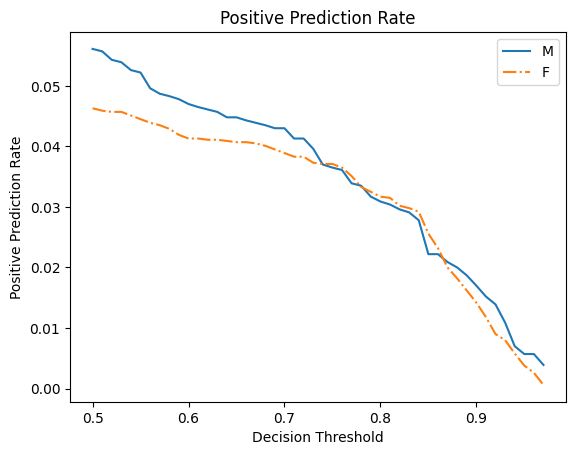

In [36]:
plt.plot(tr, df_metrics['Pos_Pred_M'], linestyle='-', label='M')
plt.plot(tr, df_metrics['Pos_Pred_F'], linestyle='-.', label='F')
plt.ylabel('Positive Prediction Rate')
plt.xlabel('Decision Threshold')
plt.title('Positive Prediction Rate') 
plt.legend()
plt.show()

### Investigate key model performance metrics
- Use the False Discovery Rate (FDR) in this example
- FDR: (Number of Incorrect Positive Predictions)/(Number of Positive Predictions)

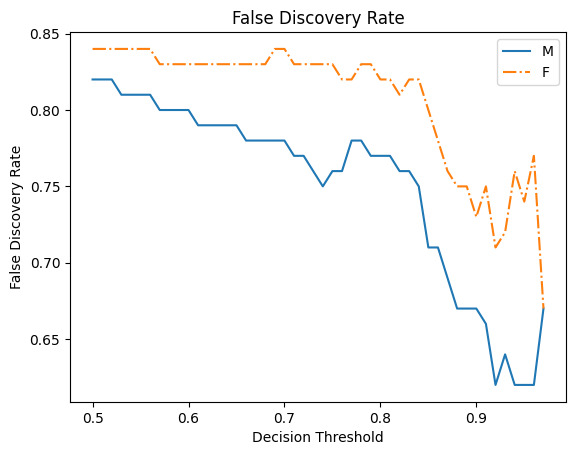

In [37]:
plt.plot(tr, df_metrics['FDR_M'], linestyle='-', label='M')
plt.plot(tr, df_metrics['FDR_F'], linestyle='-.', label='F')
plt.ylabel('False Discovery Rate')
plt.xlabel('Decision Threshold')
plt.title('False Discovery Rate') 
plt.legend()
plt.show()

### Quantify any cost incurred by the model prediction

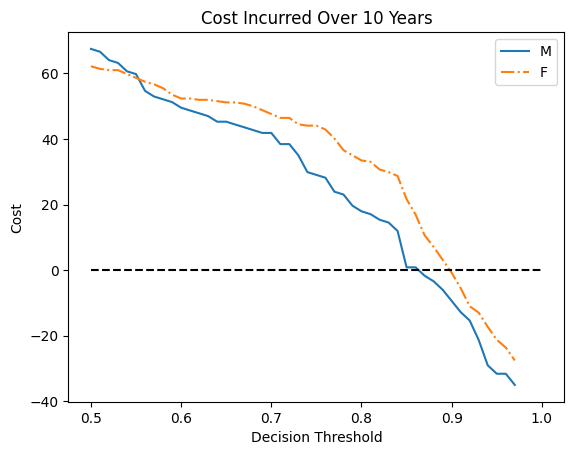

In [38]:
plt.plot(tr, df_metrics['Cost_M'], linestyle='-', label='M')
plt.plot(tr, df_metrics['Cost_F'], linestyle='-.', label='F')
plt.plot([0.5, 1],[0,0], 'k--')
plt.ylabel('Cost')
plt.xlabel('Decision Threshold')
plt.title('Cost Incurred Over 10 Years') # positive value is cost to company
plt.legend()
plt.show()

#### Comparisons
- Look at the 3 graphs side by side for comparison

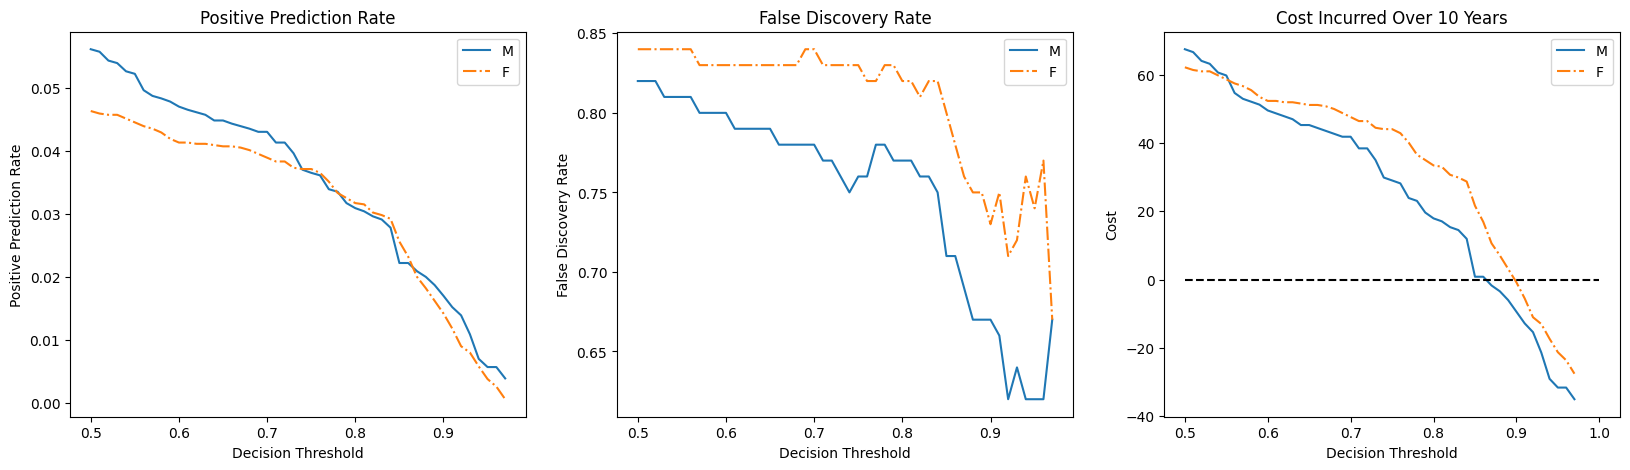

In [39]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(tr, df_metrics['Pos_Pred_M'], linestyle='-', label='M')
plt.plot(tr, df_metrics['Pos_Pred_F'], linestyle='-.', label='F')
plt.ylabel('Positive Prediction Rate')
plt.xlabel('Decision Threshold')
plt.title('Positive Prediction Rate') 
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tr, df_metrics['FDR_M'], linestyle='-', label='M')
plt.plot(tr, df_metrics['FDR_F'], linestyle='-.', label='F')
plt.ylabel('False Discovery Rate')
plt.xlabel('Decision Threshold')
plt.title('False Discovery Rate') 
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(tr, df_metrics['Cost_M'], linestyle='-', label='M')
plt.plot(tr, df_metrics['Cost_F'], linestyle='-.', label='F')
plt.plot([0.5, 1],[0,0], 'k--')
plt.ylabel('Cost')
plt.xlabel('Decision Threshold')
plt.title('Cost Incurred Over 10 Years')
plt.legend()

plt.show()